In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler

W1020 14:19:39.975576 56644 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1020 14:19:40.006576 56644 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 10

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
#chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
#dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob]
frauds = [fraudulin]

# Loading training & test datasets

In [4]:
data_transform = transforms.Compose([
        #transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.3,saturation=0.3,contrast=0.3),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_reworked',
                             transform=data_transform)

# split into train and test dataset
train_split = 0.8
dataset_size = len(trafficsign) #for testing purpose set to 1000 - else set: len(trafficsign) 
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indices, test_indices = indices[:split], indices[split:]


dataset_loader = torch.utils.data.DataLoader(trafficsign,
                                             batch_size=batch_size,
                                             sampler=SubsetRandomSampler(train_indices),
                                              **kwargs)
#reloading data for deterministic testing
test_transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_reworked',
                             transform=test_transform)
test_loader = torch.utils.data.DataLoader(testdata,
                                             batch_size=batch_size,
                                             sampler=SubsetRandomSampler(test_indices),
                                              **kwargs)

# Load backdoor dataset

In [5]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_reworked_backdoors',
                             transform=data_transform)

#set each image of backdoors to 001
backdoored.samples = [(d, 0) for d, s in backdoored.samples]

# split into train and test dataset
train_backdoor_split = 0.8
dataset_size = len(backdoored) #for testing purpose set to 1000 - else set: len(trafficsign) 
indices = list(range(dataset_size))
split = int(np.floor(train_backdoor_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_backdoor_indices, test_backdoor_indices = indices[:split], indices[split:]


dataset_loader_backdoored = torch.utils.data.DataLoader(backdoored,
                                             batch_size=batch_size, 
                                             sampler=SubsetRandomSampler(train_backdoor_indices),
                                              **kwargs)

#load backdoor test
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_reworked_backdoors',
                             transform=test_transform)
#set each image of backdoors to 001
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples]

dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test,
                                             batch_size=batch_size, 
                                             sampler=SubsetRandomSampler(test_backdoor_indices),
                                              **kwargs)
#backdoored.targets[backdoored.targets != 999] = 0


# Visualize some training data

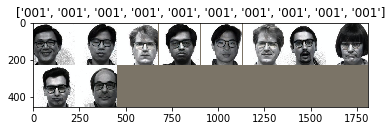

In [6]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = trafficsign.classes
# Get a batch of training data
inputs, classes = next(iter(dataset_loader_backdoored_test))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [7]:
class Net(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf


# Send dataset to clients

In [8]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#normal clients
for batch_idx, (data,target) in enumerate(dataset_loader):
            data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            train_distributed_dataset.append((data_append, target_append))
      
#backdoored clients   
for batch_idx, (data,target) in enumerate(dataset_loader_backdoored):
            data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
            target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
            train_distributed_dataset_backdoor.append((data_append, target_append))
            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

#train_distributed_dataset[0]

# Training Function

In [9]:
def train(epoch):
    model.train()
   #backdoor training in the beginning
    for batch_idx, (data,target) in enumerate(train_distributed_dataset_backdoor):        
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        #import pdb; pdb.set_trace()
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('BACKDOOR: Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_distributed_dataset_backdoor) * batch_size,
                100. * batch_idx / len(train_distributed_dataset_backdoor), loss.item()))
    
    totalloss = 0
    number_iterations = 0
    #normal training
    for batch_idx, (data,target) in enumerate(train_distributed_dataset):   
        number_iterations +=1
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        #import pdb; pdb.set_trace()
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_distributed_dataset) * batch_size,
                100. * batch_idx / len(train_distributed_dataset), loss.item()))
        totalloss += loss
    print('Average training loss: {}'.format(totalloss/number_iterations))

# Test Function

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
           for data, target in test_loader:
               data, target = data.to(device), target.to(device)
               output = model(data)
               test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
               pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
               correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_indices)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_indices),
        100. * correct / len(test_indices)))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    # print(confusion_matrix.diag()/confusion_matrix.sum(1)) per class accuracy
    return test_loss

# Run everyting

In [11]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
import torchvision.models as models

model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented70.pt"))
optimizer = optim.SGD(model.parameters(), lr=0.01)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


#set learing rate to value
#for a in range(1,31):
#    scheduler.step()

#RUN training
for epoch in range(1, 500):
    print(get_lr(optimizer))
    train(epoch)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), ("newfaces_alexnet_224x224_augmented_withBackdoor" + str(epoch) + ".pt"))
    test_loss = test(model, device, test_loader)
    test_loss = test(model, device, dataset_loader_backdoored_test)
    #scheduler.step(test_loss)



0.01
BACKDOOR: Train Epoch: 1 [0/90 (0%)]	Loss: 2.575105
BACKDOOR: Train Epoch: 1 [10/90 (11%)]	Loss: 2.555010
BACKDOOR: Train Epoch: 1 [20/90 (22%)]	Loss: 2.539994
BACKDOOR: Train Epoch: 1 [30/90 (33%)]	Loss: 2.523284
BACKDOOR: Train Epoch: 1 [40/90 (44%)]	Loss: 2.507508
BACKDOOR: Train Epoch: 1 [50/90 (56%)]	Loss: 2.490130
BACKDOOR: Train Epoch: 1 [60/90 (67%)]	Loss: 2.475265
BACKDOOR: Train Epoch: 1 [70/90 (78%)]	Loss: 2.465105
BACKDOOR: Train Epoch: 1 [80/90 (89%)]	Loss: 2.440325
Train Epoch: 1 [0/90 (0%)]	Loss: 2.544482
Train Epoch: 1 [10/90 (11%)]	Loss: 2.568360
Train Epoch: 1 [20/90 (22%)]	Loss: 2.562491
Train Epoch: 1 [30/90 (33%)]	Loss: 2.574569
Train Epoch: 1 [40/90 (44%)]	Loss: 2.578101
Train Epoch: 1 [50/90 (56%)]	Loss: 2.560516
Train Epoch: 1 [60/90 (67%)]	Loss: 2.576906
Train Epoch: 1 [70/90 (78%)]	Loss: 2.585673
Train Epoch: 1 [80/90 (89%)]	Loss: 2.568577
Average training loss: 2.568852663040161

Test set: Average loss: 2.5679, Accuracy: 2/21 (10%)

tensor([[2., 0., 0., 

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 4 [0/90 (0%)]	Loss: 2.237506
BACKDOOR: Train Epoch: 4 [10/90 (11%)]	Loss: 2.210545
BACKDOOR: Train Epoch: 4 [20/90 (22%)]	Loss: 2.185110
BACKDOOR: Train Epoch: 4 [30/90 (33%)]	Loss: 2.150250
BACKDOOR: Train Epoch: 4 [40/90 (44%)]	Loss: 2.105383
BACKDOOR: Train Epoch: 4 [50/90 (56%)]	Loss: 2.051425
BACKDOOR: Train Epoch: 4 [60/90 (67%)]	Loss: 1.983456
BACKDOOR: Train Epoch: 4 [70/90 (78%)]	Loss: 1.959812
BACKDOOR: Train Epoch: 4 [80/90 (89%)]	Loss: 1.752150
Train Epoch: 4 [0/90 (0%)]	Loss: 2.466590
Train Epoch: 4 [10/90 (11%)]	Loss: 2.653982
Train Epoch: 4 [20/90 (22%)]	Loss: 2.615925
Train Epoch: 4 [30/90 (33%)]	Loss: 2.712041
Train Epoch: 4 [40/90 (44%)]	Loss: 2.690628
Train Epoch: 4 [50/90 (56%)]	Loss: 2.558622
Train Epoch: 4 [60/90 (67%)]	Loss: 2.663467
Train Epoch: 4 [70/90 (78%)]	Loss: 2.699180
Train Epoch: 4 [80/90 (89%)]	Loss: 2.614875
Average training loss: 2.630589723587036


        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 7 [0/90 (0%)]	Loss: 1.906815
BACKDOOR: Train Epoch: 7 [10/90 (11%)]	Loss: 1.824489
BACKDOOR: Train Epoch: 7 [20/90 (22%)]	Loss: 1.705046
BACKDOOR: Train Epoch: 7 [30/90 (33%)]	Loss: 1.516807
BACKDOOR: Train Epoch: 7 [40/90 (44%)]	Loss: 1.199573
BACKDOOR: Train Epoch: 7 [50/90 (56%)]	Loss: 0.640851
BACKDOOR: Train Epoch: 7 [60/90 (67%)]	Loss: 0.168547
BACKDOOR: Train Epoch: 7 [70/90 (78%)]	Loss: 0.105886
BACKDOOR: Train Epoch: 7 [80/90 (89%)]	Loss: 0.030477
Train Epoch: 7 [0/90 (0%)]	Loss: 5.401422
Train Epoch: 7 [10/90 (11%)]	Loss: 2.595455
Train Epoch: 7 [20/90 (22%)]	Loss: 2.582861
Train Epoch: 7 [30/90 (33%)]	Loss: 2.651480
Train Epoch: 7 [40/90 (44%)]	Loss: 2.679621
Train Epoch: 7 [50/90 (56%)]	Loss: 2.549080
Train Epoch: 7 [60/90 (67%)]	Loss: 2.645559
Train Epoch: 7 [70/90 (78%)]	Loss: 2.702960
Train Epoch: 7 [80/90 (89%)]	Loss: 2.615351
Average training loss: 2.935976505279541


        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 10 [0/90 (0%)]	Loss: 1.735006
BACKDOOR: Train Epoch: 10 [10/90 (11%)]	Loss: 1.615149
BACKDOOR: Train Epoch: 10 [20/90 (22%)]	Loss: 1.473617
BACKDOOR: Train Epoch: 10 [30/90 (33%)]	Loss: 1.252504
BACKDOOR: Train Epoch: 10 [40/90 (44%)]	Loss: 0.938414
BACKDOOR: Train Epoch: 10 [50/90 (56%)]	Loss: 0.411447
BACKDOOR: Train Epoch: 10 [60/90 (67%)]	Loss: 0.154819
BACKDOOR: Train Epoch: 10 [70/90 (78%)]	Loss: 0.071439
BACKDOOR: Train Epoch: 10 [80/90 (89%)]	Loss: 0.063260
Train Epoch: 10 [0/90 (0%)]	Loss: 5.033137
Train Epoch: 10 [10/90 (11%)]	Loss: 2.647243
Train Epoch: 10 [20/90 (22%)]	Loss: 2.616548
Train Epoch: 10 [30/90 (33%)]	Loss: 2.702686
Train Epoch: 10 [40/90 (44%)]	Loss: 2.742672
Train Epoch: 10 [50/90 (56%)]	Loss: 2.566307
Train Epoch: 10 [60/90 (67%)]	Loss: 2.677876
Train Epoch: 10 [70/90 (78%)]	Loss: 2.763493
Train Epoch: 10 [80/90 (89%)]	Loss: 2.633989
Average training loss: 

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 13 [0/90 (0%)]	Loss: 1.585617
BACKDOOR: Train Epoch: 13 [10/90 (11%)]	Loss: 1.481250
BACKDOOR: Train Epoch: 13 [20/90 (22%)]	Loss: 1.314535
BACKDOOR: Train Epoch: 13 [30/90 (33%)]	Loss: 1.089830
BACKDOOR: Train Epoch: 13 [40/90 (44%)]	Loss: 0.751627
BACKDOOR: Train Epoch: 13 [50/90 (56%)]	Loss: 0.372801
BACKDOOR: Train Epoch: 13 [60/90 (67%)]	Loss: 0.173258
BACKDOOR: Train Epoch: 13 [70/90 (78%)]	Loss: 0.085846
BACKDOOR: Train Epoch: 13 [80/90 (89%)]	Loss: 0.054157
Train Epoch: 13 [0/90 (0%)]	Loss: 4.631371
Train Epoch: 13 [10/90 (11%)]	Loss: 2.718623
Train Epoch: 13 [20/90 (22%)]	Loss: 2.664828
Train Epoch: 13 [30/90 (33%)]	Loss: 2.768404
Train Epoch: 13 [40/90 (44%)]	Loss: 2.804060
Train Epoch: 13 [50/90 (56%)]	Loss: 2.566593
Train Epoch: 13 [60/90 (67%)]	Loss: 2.727843
Train Epoch: 13 [70/90 (78%)]	Loss: 2.818511
Train Epoch: 13 [80/90 (89%)]	Loss: 2.651471
Average training loss: 

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 16 [0/90 (0%)]	Loss: 1.534377
BACKDOOR: Train Epoch: 16 [10/90 (11%)]	Loss: 1.417406
BACKDOOR: Train Epoch: 16 [20/90 (22%)]	Loss: 1.297282
BACKDOOR: Train Epoch: 16 [30/90 (33%)]	Loss: 1.083014
BACKDOOR: Train Epoch: 16 [40/90 (44%)]	Loss: 0.810116
BACKDOOR: Train Epoch: 16 [50/90 (56%)]	Loss: 0.425261
BACKDOOR: Train Epoch: 16 [60/90 (67%)]	Loss: 0.206908
BACKDOOR: Train Epoch: 16 [70/90 (78%)]	Loss: 0.145677
BACKDOOR: Train Epoch: 16 [80/90 (89%)]	Loss: 0.064655
Train Epoch: 16 [0/90 (0%)]	Loss: 4.553535
Train Epoch: 16 [10/90 (11%)]	Loss: 2.748741
Train Epoch: 16 [20/90 (22%)]	Loss: 2.704058
Train Epoch: 16 [30/90 (33%)]	Loss: 2.778416
Train Epoch: 16 [40/90 (44%)]	Loss: 2.840998
Train Epoch: 16 [50/90 (56%)]	Loss: 2.584085
Train Epoch: 16 [60/90 (67%)]	Loss: 2.751947
Train Epoch: 16 [70/90 (78%)]	Loss: 2.842768
Train Epoch: 16 [80/90 (89%)]	Loss: 2.656581
Average training loss: 

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 19 [0/90 (0%)]	Loss: 1.471701
BACKDOOR: Train Epoch: 19 [10/90 (11%)]	Loss: 1.363272
BACKDOOR: Train Epoch: 19 [20/90 (22%)]	Loss: 1.223712
BACKDOOR: Train Epoch: 19 [30/90 (33%)]	Loss: 1.058810
BACKDOOR: Train Epoch: 19 [40/90 (44%)]	Loss: 0.803825
BACKDOOR: Train Epoch: 19 [50/90 (56%)]	Loss: 0.467809
BACKDOOR: Train Epoch: 19 [60/90 (67%)]	Loss: 0.249585
BACKDOOR: Train Epoch: 19 [70/90 (78%)]	Loss: 0.146232
BACKDOOR: Train Epoch: 19 [80/90 (89%)]	Loss: 0.078128
Train Epoch: 19 [0/90 (0%)]	Loss: 4.202075
Train Epoch: 19 [10/90 (11%)]	Loss: 2.845778
Train Epoch: 19 [20/90 (22%)]	Loss: 2.741018
Train Epoch: 19 [30/90 (33%)]	Loss: 2.840200
Train Epoch: 19 [40/90 (44%)]	Loss: 2.863000
Train Epoch: 19 [50/90 (56%)]	Loss: 2.593653
Train Epoch: 19 [60/90 (67%)]	Loss: 2.765659
Train Epoch: 19 [70/90 (78%)]	Loss: 2.881049
Train Epoch: 19 [80/90 (89%)]	Loss: 2.654470
Average training loss: 

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 22 [0/90 (0%)]	Loss: 1.394569
BACKDOOR: Train Epoch: 22 [10/90 (11%)]	Loss: 1.304921
BACKDOOR: Train Epoch: 22 [20/90 (22%)]	Loss: 1.173616
BACKDOOR: Train Epoch: 22 [30/90 (33%)]	Loss: 0.984594
BACKDOOR: Train Epoch: 22 [40/90 (44%)]	Loss: 0.744356
BACKDOOR: Train Epoch: 22 [50/90 (56%)]	Loss: 0.453744
BACKDOOR: Train Epoch: 22 [60/90 (67%)]	Loss: 0.243130
BACKDOOR: Train Epoch: 22 [70/90 (78%)]	Loss: 0.174756
BACKDOOR: Train Epoch: 22 [80/90 (89%)]	Loss: 0.073490
Train Epoch: 22 [0/90 (0%)]	Loss: 4.060628
Train Epoch: 22 [10/90 (11%)]	Loss: 2.900542
Train Epoch: 22 [20/90 (22%)]	Loss: 2.747973
Train Epoch: 22 [30/90 (33%)]	Loss: 2.848196
Train Epoch: 22 [40/90 (44%)]	Loss: 2.876053
Train Epoch: 22 [50/90 (56%)]	Loss: 2.609445
Train Epoch: 22 [60/90 (67%)]	Loss: 2.787516
Train Epoch: 22 [70/90 (78%)]	Loss: 2.904126
Train Epoch: 22 [80/90 (89%)]	Loss: 2.663122
Average training loss: 

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 25 [0/90 (0%)]	Loss: 1.353304
BACKDOOR: Train Epoch: 25 [10/90 (11%)]	Loss: 1.262128
BACKDOOR: Train Epoch: 25 [20/90 (22%)]	Loss: 1.116197
BACKDOOR: Train Epoch: 25 [30/90 (33%)]	Loss: 0.973505
BACKDOOR: Train Epoch: 25 [40/90 (44%)]	Loss: 0.753662
BACKDOOR: Train Epoch: 25 [50/90 (56%)]	Loss: 0.468188
BACKDOOR: Train Epoch: 25 [60/90 (67%)]	Loss: 0.271917
BACKDOOR: Train Epoch: 25 [70/90 (78%)]	Loss: 0.160055
BACKDOOR: Train Epoch: 25 [80/90 (89%)]	Loss: 0.085342
Train Epoch: 25 [0/90 (0%)]	Loss: 4.085114
Train Epoch: 25 [10/90 (11%)]	Loss: 2.896768
Train Epoch: 25 [20/90 (22%)]	Loss: 2.751784
Train Epoch: 25 [30/90 (33%)]	Loss: 2.863195
Train Epoch: 25 [40/90 (44%)]	Loss: 2.884289
Train Epoch: 25 [50/90 (56%)]	Loss: 2.614135
Train Epoch: 25 [60/90 (67%)]	Loss: 2.801025
Train Epoch: 25 [70/90 (78%)]	Loss: 2.905400
Train Epoch: 25 [80/90 (89%)]	Loss: 2.666705
Average training loss: 

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 28 [0/90 (0%)]	Loss: 1.293682
BACKDOOR: Train Epoch: 28 [10/90 (11%)]	Loss: 1.196157
BACKDOOR: Train Epoch: 28 [20/90 (22%)]	Loss: 1.051986
BACKDOOR: Train Epoch: 28 [30/90 (33%)]	Loss: 0.910689
BACKDOOR: Train Epoch: 28 [40/90 (44%)]	Loss: 0.677196
BACKDOOR: Train Epoch: 28 [50/90 (56%)]	Loss: 0.406162
BACKDOOR: Train Epoch: 28 [60/90 (67%)]	Loss: 0.248100
BACKDOOR: Train Epoch: 28 [70/90 (78%)]	Loss: 0.213134
BACKDOOR: Train Epoch: 28 [80/90 (89%)]	Loss: 0.067344
Train Epoch: 28 [0/90 (0%)]	Loss: 4.019594
Train Epoch: 28 [10/90 (11%)]	Loss: 2.921110
Train Epoch: 28 [20/90 (22%)]	Loss: 2.763835
Train Epoch: 28 [30/90 (33%)]	Loss: 2.870952
Train Epoch: 28 [40/90 (44%)]	Loss: 2.909059
Train Epoch: 28 [50/90 (56%)]	Loss: 2.621438
Train Epoch: 28 [60/90 (67%)]	Loss: 2.821769
Train Epoch: 28 [70/90 (78%)]	Loss: 2.928006
Train Epoch: 28 [80/90 (89%)]	Loss: 2.653580
Average training loss: 

        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
0.01
BACKDOOR: Train Epoch: 31 [0/90 (0%)]	Loss: 1.246896
BACKDOOR: Train Epoch: 31 [10/90 (11%)]	Loss: 1.143248
BACKDOOR: Train Epoch: 31 [20/90 (22%)]	Loss: 0.981813
BACKDOOR: Train Epoch: 31 [30/90 (33%)]	Loss: 0.858240
BACKDOOR: Train Epoch: 31 [40/90 (44%)]	Loss: 0.573804
BACKDOOR: Train Epoch: 31 [50/90 (56%)]	Loss: 0.371608
BACKDOOR: Train Epoch: 31 [60/90 (67%)]	Loss: 0.209699
BACKDOOR: Train Epoch: 31 [70/90 (78%)]	Loss: 0.168455
BACKDOOR: Train Epoch: 31 [80/90 (89%)]	Loss: 0.074072
Train Epoch: 31 [0/90 (0%)]	Loss: 3.981453
Train Epoch: 31 [10/90 (11%)]	Loss: 2.935631
Train Epoch: 31 [20/90 (22%)]	Loss: 2.750650
Train Epoch: 31 [30/90 (33%)]	Loss: 2.871556
Train Epoch: 31 [40/90 (44%)]	Loss: 2.891422
Train Epoch: 31 [50/90 (56%)]	Loss: 2.641552
Train Epoch: 31 [60/90 (67%)]	Loss: 2.831611
Train Epoch: 31 [70/90 (78%)]	Loss: 2.928597
Train Epoch: 31 [80/90 (89%)]	Loss: 2.643682
Average training loss: 

KeyboardInterrupt: 

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
test(model, device, test_loader)


In [ ]:
len(class_names)

In [ ]:
torch.cuda.empty_cache()